In [1]:
import pandas as pd
import numpy as np
import scipy.io
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist

from nltk.cluster import kmeans

In [372]:
DIRECTORY = "../data/20110706"
NSENSORS = 128
data = pd.DataFrame({i: scipy.io.loadmat(f'{DIRECTORY}/LFP_ch{i}.mat')['LFP'][0]
                     for i in range(1, 1 + NSENSORS)})

In [373]:
movies = pd.Series(index=scipy.io.loadmat(f"{DIRECTORY}/Movie_start_time.mat")['Movie_start_time'][0],
                   data=scipy.io.loadmat(f"{DIRECTORY}/Task_info.mat")['SessionData'][0][0][3].reshape(-1))
movies[0] = 0
data['movie'] = movies

In [374]:
data['movie'] = data['movie'].fillna(method='ffill')

In [375]:
%matplotlib inline

In [376]:
raw_df = data.copy()

# Window size choice

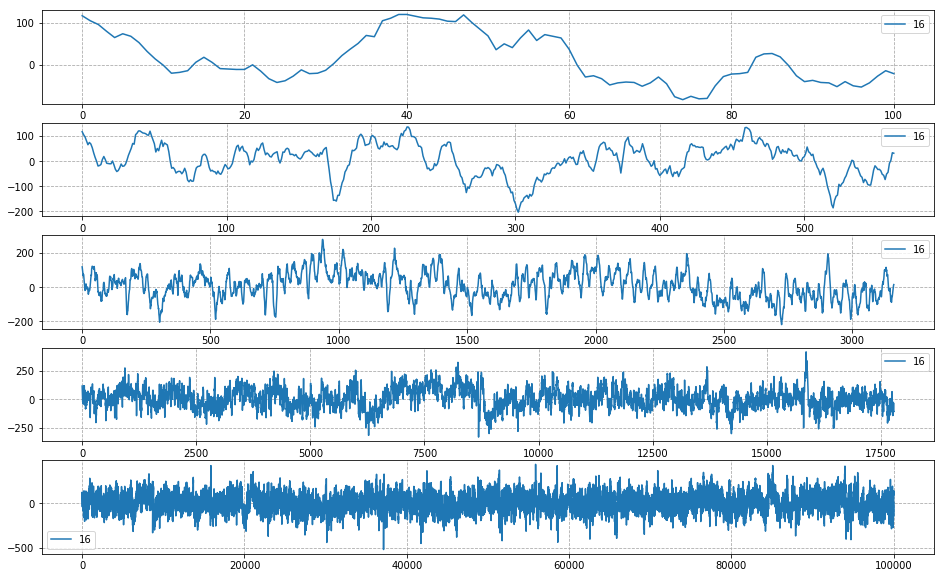

In [379]:
N = 5
fig, axes = plt.subplots(figsize=(16, 10), nrows=N, ncols=1)
axes = iter(axes)

for size in np.logspace(2, 5, N):
    ax = next(axes)
    raw_df[[16]].loc[0:size].plot(ax=ax)
    ax.grid(color='#AAAAAA', ls='--')

In [380]:
SAMPLE_SIZE = 300
OVERLAP = 10

# Split into series of `SAMPLE_SIZE` length with `OVERLAP` overlap

In [381]:
step = SAMPLE_SIZE - OVERLAP
series = [raw_df.loc[start : start + SAMPLE_SIZE - 1].reset_index(drop=True)
          for start in range(0, len(raw_df) - len(raw_df) % step, step)]

In [382]:
data = pd.concat(series, keys=range(0, len(series)))
data.index.names = ['datapoint', 't']

# Select `N_CHANNELS` channels

In [383]:
data = data.loc[:, [3, 'movie']]

# Test DTW with various parameters

In [384]:
from dtwalign import dtw, dtw_low
import dtwalign

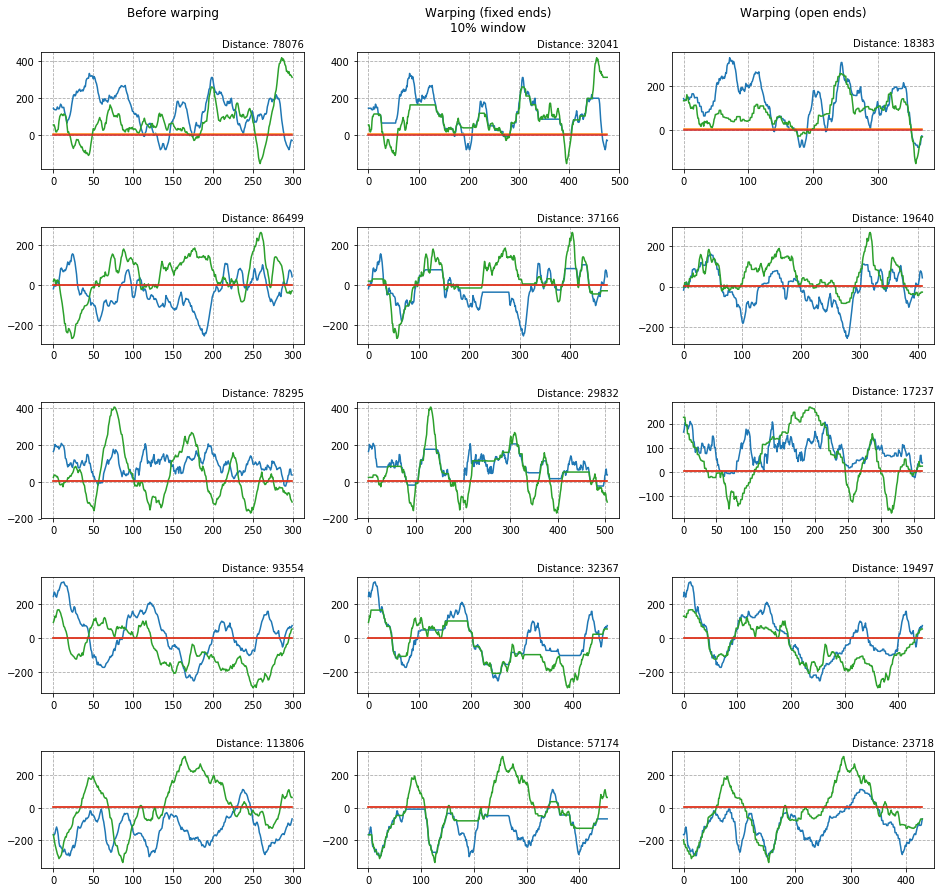

In [385]:
N = 5

fig, axes = plt.subplots(figsize = (16, 3*N) , nrows=N, ncols=3)

axes[0][0].set_title('Before warping\n\n')
axes[0][1].set_title('Warping (fixed ends)\n10% window\n')
axes[0][2].set_title('Warping (open ends)\n\n')

axes = iter(axes)

for n1, n2 in np.random.randint(0, len(series), (N, 2)):
    ax = next(axes)
    x = data.loc[n1].values
    y = data.loc[n2].values
    
    def _plot_aligned(ax, x, y, x_path, y_path, distance):
        ax.grid(color='#aaaaaa', ls='--')
        
        ax.plot(x[x_path])
        ax.plot(y[y_path])
        ax.text(ax.get_xlim()[1], ax.get_ylim()[1] + 30, f"Distance: {distance:.0f}", ha='right')
        
    res = dtw(x, y, window_type="sakoechiba", window_size=0)
    _plot_aligned(ax[0], x, y, x_path=res.path[:, 0], y_path=res.path[:, 1], distance=res.distance)

    res = dtw(x, y, window_type="sakoechiba", window_size=SAMPLE_SIZE*0.1)
    _plot_aligned(ax[1], x, y, x_path=res.path[:, 0], y_path=res.path[:, 1], distance=res.distance)
    
    X = cdist(x, y, metric="euclidean")
    res = dtw_low(X, open_end=True, open_begin=True,
              window=dtwalign.window.NoWindow(len(x), len(y)),
              pattern=dtwalign.step_pattern.AsymmetricP05())
    
    _plot_aligned(ax[2], x, y, x_path=res.path[:, 0], y_path=res.path[:, 1], distance=res.distance)
    
plt.subplots_adjust(hspace=0.5)

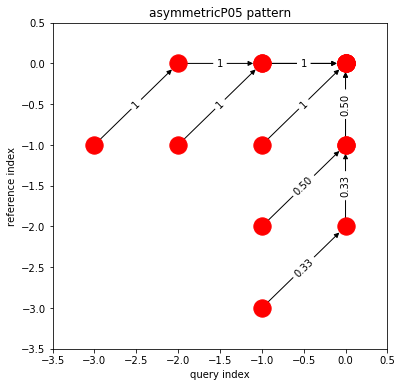

In [386]:
dtwalign.step_pattern.AsymmetricP05().plot()

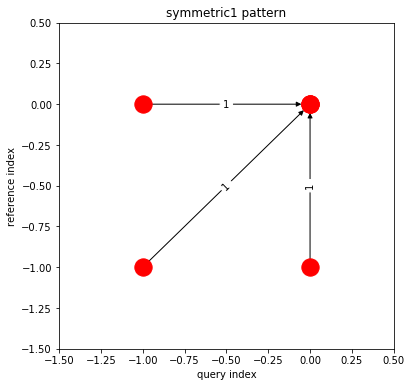

In [387]:
dtwalign.step_pattern.Symmetric1().plot()

# WIP: K-means clusterization

In [388]:
from typing import List

In [389]:
def dtw_distance(x: List[float], y: List[float]):
    x = x.reshape(1, -1).transpose()
    y = y.reshape(1, -1).transpose()
    X = cdist(x, y, metric="euclidean")
    return(dtw_low(X, open_end=True, open_begin=True, dist_only=True,
              window=dtwalign.window.NoWindow(len(x), len(y)),
              pattern=dtwalign.step_pattern.AsymmetricP05()).distance)

In [135]:
model = kmeans.KMeansClusterer(num_means=10, distance=dtw_distance)

In [ ]:
model.cluster_vectorspace()

# Train-Test split

In [391]:
from sklearn.model_selection import train_test_split

In [392]:
X = data.drop('movie', axis=1).unstack('t')
y = data['movie'].groupby(level='datapoint').first()

In [393]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=60,
                                                    train_size=7600,
                                                    random_state=54645)
X_train = X_train.copy()
y_train = y_train.copy()

# Random clustering

In [394]:
X_train['movie'] = y_train

In [395]:
X_train.set_index('movie', inplace=True)

In [396]:
X_train.sort_index(inplace=True)

In [341]:
from tqdm import tqdm

In [400]:
distances = []
y_predicted = []

for i, test_row in tqdm(list(X_test.iterrows())):
    for j, train_row in X_train.iterrows():
        distances.append(dtw_distance(train_row[3].values,
                                      test_row[3].values))
    X_train['dist'] = distances
    distances.clear()
    y_predicted.append(X_train['dist'].groupby(level='movie').mean().idxmin())

100%|██████████| 60/60 [2:33:21<00:00, 148.88s/it]


In [346]:
results = pd.DataFrame(y_test)
results['predicted'] = y_predicted

In [351]:
from sklearn.metrics import accuracy_score, confusion_matrix

In [402]:
accuracy_score(y_predicted, y_test)

0.03333333333333333